 * Running on http://localhost:5000
Press CTRL+C to quit


127.0.0.1 - - [31/Mar/2025 13:00:31] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [31/Mar/2025 13:00:31] "GET /static/style.css HTTP/1.1" 200 -
127.0.0.1 - - [31/Mar/2025 13:00:39] "POST /upload HTTP/1.1" 200 -
127.0.0.1 - - [31/Mar/2025 13:00:39] "GET /static/style.css HTTP/1.1" 304 -
127.0.0.1 - - [31/Mar/2025 13:00:54] "POST /generate-graph HTTP/1.1" 200 -
127.0.0.1 - - [31/Mar/2025 13:00:54] "GET /static/style.css HTTP/1.1" 304 -


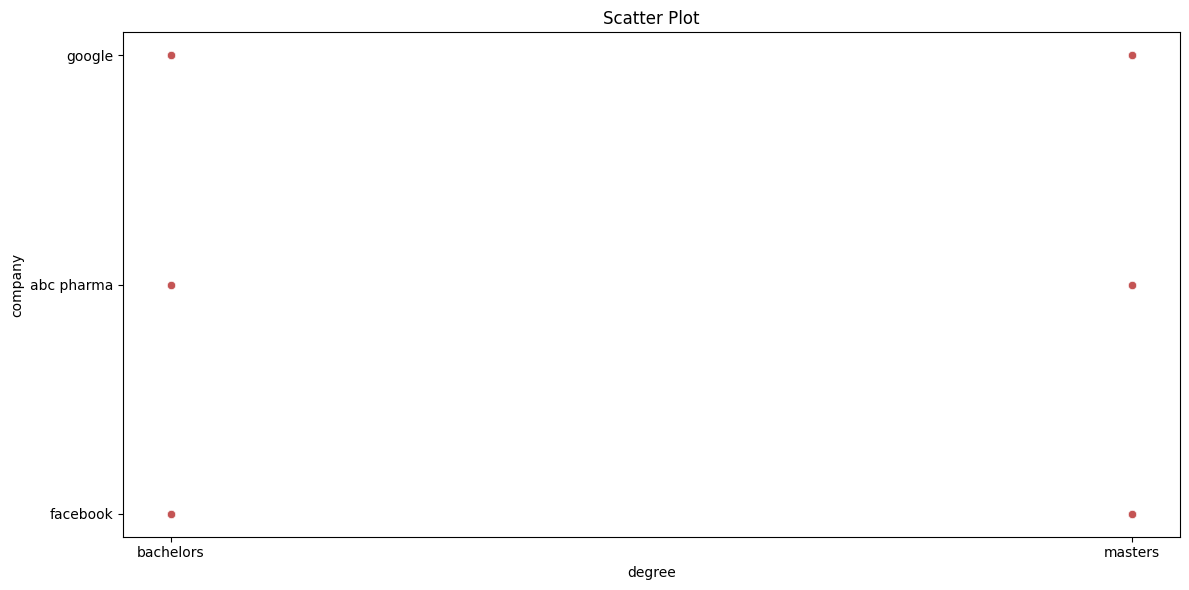

In [2]:
from flask import Flask, render_template, request, send_file
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import io
import base64
from werkzeug.serving import run_simple

app = Flask(__name__)
UPLOAD_FOLDER = "uploads"
app.config[UPLOAD_FOLDER] = "uploads"
os.makedirs(app.config[UPLOAD_FOLDER] , exist_ok=True)

def cleanup_files():
    for file in os.listdir(UPLOAD_FOLDER):
        file_path = os.path.join(UPLOAD_FOLDER, file)
        os.remove(file_path)

@app.route('/')
def index():
    cleanup_files()
    return render_template('index.html')

@app.route('/upload', methods=['POST'])
def upload_file():
    if 'file' not in request.files:
        return 'No file part'

    file = request.files['file']
    if file.filename == '':
        return 'No file selected'

    if file:
        file_path = os.path.join(app.config[UPLOAD_FOLDER], file.filename)
        file.save(file_path)
        df = pd.read_csv(file_path)

        table_name = os.path.splitext(file.filename)[0]

        total_columns = len(df.columns)
        total_rows = len(df)
        column_names = df.columns.tolist()

        table_html = df.head(6).to_html()
        return render_template(
            'index.html',
            table=table_html,
            filename=file.filename,
            table_name=table_name,
            columns=df.columns.tolist(),
            total_columns=total_columns,
            total_rows=total_rows,
            column_names=column_names
        )

@app.route('/generate-graph', methods=['POST'])
def generate_graph():
    graph_type = request.form['graph_type']
    graph_color = request.form['graph_color']  # Get the selected color
    filename = request.form['filename']
    x_column = request.form['x_column']
    y_column = request.form.get('y_column')

    file_path = os.path.join(app.config[UPLOAD_FOLDER], filename)
    if not os.path.exists(file_path):
        return "File not found. Please upload again."

    df = pd.read_csv(file_path)

    plt.figure(figsize=(12, 6))  

    if graph_type == 'bar':
        sns.barplot(x=df[x_column], y=df[y_column], color=graph_color)
        plt.title("Bar Chart")
    elif graph_type == 'scatter':
        sns.scatterplot(x=df[x_column], y=df[y_column], color=graph_color)
        plt.title("Scatter Plot")
    elif graph_type == 'line':
        sns.lineplot(x=df[x_column], y=df[y_column], color=graph_color)
        plt.title("Line Graph")
    elif graph_type == 'histogram':
        sns.histplot(df[x_column], kde=True, color=graph_color)
        plt.title("Histogram")
    elif graph_type == 'box':
        sns.boxplot(x=df[x_column], y=df[y_column], color=graph_color)
        plt.title("Box Plot")
    else:
        return "Invalid graph type selected."

    img = io.BytesIO()
    plt.xticks(rotation=0) 
    plt.draw()  
    ax = plt.gca()
    x_labels = ax.get_xticklabels()
    
    if len(x_labels) > 10: 
        step = max(1, len(x_labels) // 10)
        plt.xticks(ticks=range(0, len(x_labels), step), labels=[label.get_text() for i, label in enumerate(x_labels) if i % step == 0], rotation=45, ha='right')
    
    y_labels = ax.get_yticklabels()
    
    if any(label.get_window_extent().height > ax.figure.get_size_inches()[1] * ax.figure.dpi / len(y_labels) for label in y_labels):
        plt.yticks(rotation=45, va='top')
    
    plt.tight_layout()

    # Save the graph as a file
    graph_filename = f"graph_{filename.split('.')[0]}.png"
    graph_filepath = os.path.join(app.config[UPLOAD_FOLDER], graph_filename)
    plt.savefig(graph_filepath)

    # Encode the graph for inline display
    plt.savefig(img, format='png')
    img.seek(0)
    graph_url = base64.b64encode(img.getvalue()).decode()

    graph_html = f'<img src="data:image/png;base64,{graph_url}" class="img-fluid">'

    # Provide the download URL
    download_url = f"/download-graph/{graph_filename}"

    return render_template('index.html', table=df.head().to_html(), filename=filename, plot=graph_html, columns=df.columns.tolist(), download_url=download_url)

@app.route('/download-graph/<graph_filename>')
def download_graph(graph_filename):
    graph_filepath = os.path.join(app.config[UPLOAD_FOLDER], graph_filename)
    if not os.path.exists(graph_filepath):
        return "Graph file not found."
    return send_file(graph_filepath, as_attachment=True)

@app.route('/about_graphs')
def about_graphs():
    return render_template('about_graphs.html')

if __name__ == '__main__':
    run_simple('localhost', 5000, app)